In [1]:
import os
import cv2
from tensorflow.keras.applications import EfficientNetB0

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import offsetbox
from sklearn import manifold
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from time import time
import json
import pandas as pd

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
data = []
with open('/home/pag/Documents/suivi_OC/data/yelp/yelp_photos/photos.json') as f:
    for line in f:
        data.append(json.loads(line))
        
df = pd.DataFrame(data)

FileNotFoundError: [Errno 2] No such file or directory: '/home/pag/Documents/suivi_OC/data/yelp/yelp_photos/photos.json'

In [25]:
def stratified_sample_df(df, col, n_samples):
    n = min(n_samples, df[col].value_counts().min())
    df_ = df.groupby(col).apply(lambda x: x.sample(n))
    df_.index = df_.index.droplevel(0)
    return df_

subsampled_df = stratified_sample_df(df, 'label', 500)

### Feature extraction

In [19]:
model = EfficientNetB0(include_top=False, weights='imagenet', pooling='avg')

In [26]:
features_list = []
images_list = []
for i, im in enumerate(subsampled_df['photo_id'].tolist()):
    im_path = os.path.join('/home/pag/Documents/suivi_OC/data/yelp/yelp_photos/photos/', im + '.jpg')
    im_arr = cv2.imread(im_path)
    im_feat = model(im_arr).numpy()[0]
    features_list.append((im, im_feat))

KeyboardInterrupt: 

### Réduction TNSE et visualisation

In [31]:
features = [feat[1] for feat in features_list]
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(np.stack(features))

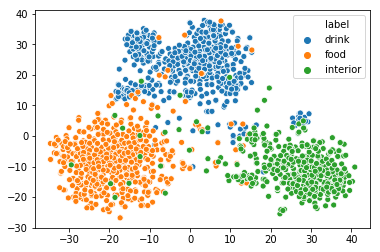

In [42]:
sns.scatterplot(X_tsne[:, 0], X_tsne[:, 1], hue=subsampled_df.iloc[:X_tsne.shape[0], 3])

### Apprentissage d'un classifieur

In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    np.stack(features), subsampled_df.iloc[:X_tsne.shape[0], 3], test_size=0.33, random_state=42)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [62]:
pca = PCA(n_components=10)
pca.fit(X_train_std)

X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

In [63]:
params = {'max_depth': range(5, 20, 3)}
model = RandomForestClassifier(n_estimators=200, random_state=0)
clf = GridSearchCV(model, params)
clf.fit(X_train_pca, y_train)

GridSearchCV(estimator=RandomForestClassifier(n_estimators=200, random_state=0),
             param_grid={'max_depth': range(5, 20, 3)})

In [65]:
clf.best_params_

{'max_depth': 8}

In [64]:
clf.score(X_test_pca, y_test)

0.9562363238512035